In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
from matplotlib import pyplot
# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

import yfinance as yf
import yahoo_fin.stock_info as si
# import pandas_datareader.data as web

from dateutil.relativedelta import relativedelta
from datetime import datetime

pd.set_option('display.max_rows', None, 'display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# treat inf as Nan
pd.set_option('use_inf_as_na', True)

## Model 1 
#### Target T0_5>0 --> Event 
#### Target T0_5<0 --> Non-event

In [2]:
dfmdl1=pd.read_csv('data/model_1.csv')

In [3]:
dfmdl1.shape

(8259, 84)

In [4]:
dfmdl1.isna().sum()

Ticker                     0
beta_30avg                13
adjclose                  13
Fiscal Year                0
Fiscal Period              0
Revenue                    4
Net_income                 0
Shares                     0
Cash                       7
Assets                     0
CFO                        0
CAPX                    4450
Dividends               1844
FCF                        0
EPSsuprise_ind             0
Revenue_qoq              417
Revenue_yoy             1731
Net_Income_qoq           418
Net_Income_yoy          1732
Gross_margin             403
Gross_margin_qoq         810
Gross_margin_yoy        2075
Operating_margin           4
Operating_margin_qoq     423
Operating_margin_yoy    1739
Net_margin                 4
Net_margin_qoq           423
Net_margin_yoy          1739
Cash_yoy                1733
Assets_yoy              1731
Leverage                   0
CFO_qoq                  418
FCF_qoq                  431
Sector                     0
Industry      

### Step 1. Logic to fill missing values

In [5]:
# Drop rows where the target is missing
dfmdl1=dfmdl1.dropna(subset=['T0_5'])
dfmdl1.shape

(7841, 84)

In [6]:
# Assume following attributes as 0 when missing
dfmdl1['CAPX'] = dfmdl1['CAPX'].fillna(0)
dfmdl1['Dividends'] = dfmdl1['Dividends'].fillna(0)
dfmdl1['Dividend_yields_new'] = dfmdl1['Dividend_yields_new'].fillna(0)
dfmdl1['Assets_yoy'] = dfmdl1['Assets_yoy'].fillna(0)
dfmdl1['Cash_yoy'] = dfmdl1['Cash_yoy'].fillna(0)
dfmdl1['CFO_qoq'] = dfmdl1['CFO_qoq'].fillna(0)
dfmdl1['FCF_qoq'] = dfmdl1['FCF_qoq'].fillna(0)

# Assume missing gross margin = net margin  (rationale: certain industry doesn't report gross margin)
dfmdl1['Gross_margin'] = dfmdl1['Gross_margin'].fillna(dfmdl1['Operating_margin'])

# Assume missing QoQ change from average
dfmdl1["Revenue_qoq"]  = dfmdl1['Revenue_qoq'].fillna(dfmdl1.groupby('Ticker')['Revenue_qoq'].transform('mean'))
dfmdl1["Net_Income_qoq"]  = dfmdl1['Net_Income_qoq'].fillna(dfmdl1.groupby('Ticker')['Net_Income_qoq'].transform('mean'))
dfmdl1["Gross_margin_qoq"]  = dfmdl1['Gross_margin_qoq'].fillna(dfmdl1.groupby('Ticker')['Gross_margin_qoq'].transform('mean'))
dfmdl1["Operating_margin_qoq"]  = dfmdl1['Operating_margin_qoq'].fillna(dfmdl1.groupby('Ticker')['Operating_margin_qoq'].transform('mean'))
dfmdl1["Net_margin_qoq"]  = dfmdl1['Net_margin_qoq'].fillna(dfmdl1.groupby('Ticker')['Net_margin_qoq'].transform('mean'))
# if still missing: 
dfmdl1["Gross_margin_qoq"]  = dfmdl1['Gross_margin_qoq'].fillna(dfmdl1['Operating_margin_qoq'])


# Assume missing YoY change is interpolated from QoQ 
def interpolation(df,var):
    df[var+'_yoy'].fillna((1+df[var+'_qoq'])**4-1, inplace=True)
    return df

for var in ['Revenue','Net_Income','Gross_margin','Operating_margin','Net_margin']:
    interpolation(dfmdl1,var)

# Assume missing sentiment score from ticker's average, it still missing then 0
dfmdl1["cs_last5"]  = dfmdl1['cs_last5'].fillna(dfmdl1.groupby('Ticker')['cs_last5'].transform('mean'))
dfmdl1['cs_last5'] = dfmdl1['cs_last5'].fillna(0)

In [7]:
dfmdl1.isna().sum()

Ticker                   0
beta_30avg              12
adjclose                12
Fiscal Year              0
Fiscal Period            0
Revenue                  4
Net_income               0
Shares                   0
Cash                     5
Assets                   0
CFO                      0
CAPX                     0
Dividends                0
FCF                      0
EPSsuprise_ind           0
Revenue_qoq              3
Revenue_yoy              3
Net_Income_qoq           5
Net_Income_yoy           4
Gross_margin             4
Gross_margin_qoq         3
Gross_margin_yoy         3
Operating_margin         4
Operating_margin_qoq     3
Operating_margin_yoy     3
Net_margin               4
Net_margin_qoq           3
Net_margin_yoy           3
Cash_yoy                 0
Assets_yoy               0
Leverage                 0
CFO_qoq                  0
FCF_qoq                  0
Sector                   0
Industry                 0
Next_EarningDate         0
RSI                      0
M

In [8]:
# drop rows still with NA (should be less than 12)
dfmdl1.dropna(inplace=True)
dfmdl1.shape

(7811, 84)

In [9]:
dfmdl1.isna().sum().sum()

0

### Step 2. Define Target

In [10]:
dfmdl1['target'] = np.where(dfmdl1['T0_5']>0, 1, 0)

### Step 3. Data Exploration

In [11]:
dfmdl1.columns

Index(['Ticker', 'beta_30avg', 'adjclose', 'Fiscal Year', 'Fiscal Period',
       'Revenue', 'Net_income', 'Shares', 'Cash', 'Assets', 'CFO', 'CAPX',
       'Dividends', 'FCF', 'EPSsuprise_ind', 'Revenue_qoq', 'Revenue_yoy',
       'Net_Income_qoq', 'Net_Income_yoy', 'Gross_margin', 'Gross_margin_qoq',
       'Gross_margin_yoy', 'Operating_margin', 'Operating_margin_qoq',
       'Operating_margin_yoy', 'Net_margin', 'Net_margin_qoq',
       'Net_margin_yoy', 'Cash_yoy', 'Assets_yoy', 'Leverage', 'CFO_qoq',
       'FCF_qoq', 'Sector', 'Industry', 'Next_EarningDate', 'RSI', 'MFI',
       'adjclose_SMA_12', 'adjclose_SMA_30', 'adjclose_EWMA_12',
       'adjclose_EWMA_30', 'adjclose_UpperBand', 'adjclose_LowerBand',
       'SMA_12_SMA_30', 'EWMA_12_EWMA_30', 'UpperBand_LowerBand', '^GSPC',
       '^GSPC_pctchange_5', '^GSPC_pctchange_21', '^GSPC_pctchange_yoy',
       '^RUT', '^RUT_pctchange_5', '^RUT_pctchange_21', '^RUT_pctchange_yoy',
       '^VIX', '^VIX_pctchange_5', '^VIX_pctchange_2

In [12]:
dfmdl1.describe()

,beta_30avg,adjclose,Fiscal Year,Revenue,Net_income,Shares,Cash,Assets,CFO,CAPX,Dividends,FCF,Revenue_qoq,Revenue_yoy,Net_Income_qoq,Net_Income_yoy,Gross_margin,Gross_margin_qoq,Gross_margin_yoy,Operating_margin,Operating_margin_qoq,Operating_margin_yoy,Net_margin,Net_margin_qoq,Net_margin_yoy,Cash_yoy,Assets_yoy,Leverage,CFO_qoq,FCF_qoq,RSI,MFI,adjclose_SMA_12,adjclose_SMA_30,adjclose_EWMA_12,adjclose_EWMA_30,adjclose_UpperBand,adjclose_LowerBand,SMA_12_SMA_30,EWMA_12_EWMA_30,UpperBand_LowerBand,^GSPC,^GSPC_pctchange_5,^GSPC_pctchange_21,^GSPC_pctchange_yoy,^RUT,^RUT_pctchange_5,^RUT_pctchange_21,^RUT_pctchange_yoy,^VIX,^VIX_pctchange_5,^VIX_pctchange_21,^VIX_pctchange_yoy,GC=F,GC=F_pctchange_5,GC=F_pctchange_21,GC=F_pctchange_yoy,CL=F,CL=F_pctchange_5,CL=F_pctchange_21,CL=F_pctchange_yoy,^TNX,^TNX_pctchange_5,^TNX_pctchange_21,^TNX_pctchange_yoy,^FVX,^FVX_pctchange_5,^FVX_pctchange_21,^FVX_pctchange_yoy,cs_last5,T0,sameday_jump,T0_5,PE_new,PS_new,PB_new,Dividend_yields_new,Market_cap_mm,target
count,7811.000000,7811.000000,7811.000000,7.811000e+03,7.811000e+03,7.811000e+03,7.811000e+03,7.811000e+03,7.811000e+03,7.811000e+03,7.811000e+03,7.811000e+03,7811.000000,7.811000e+03,7811.000000,7.811000e+03,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7.811000e+03,7811.000000
mean,0.987890,110.048690,2018.181027,5.637686e+09,4.857689e+08,6.498256e+08,3.914169e+09,3.516209e+10,8.981464e+08,1.517504e+07,-2.459358e+08,7.374899e+07,0.029186,4.192672e+02,0.192820,1.316949e+07,0.443644,-0.003548,7.787397,0.121191,-0.019172,0.050178,0.053727,-0.023214,0.343886,0.548916,0.095960,1.823681,-0.209128,-2.030237,53.545332,53.877581,1.003343,1.013554,0.944942,0.950835,0.948284,1.096892,1.009357,1.005218,1.169318,2914.393583,0.148721,2.089736,13.266175,1573.114926,0.207635,2.052263,12.464433,18.291303,3.494741,5.423270,25.834249,1456.365203,0.147504,1.090133,10.062840,53.318391,0.742787,0.824905,15.011572,2.005605,0.281668,1.154806,5.847617,1.665537,-0.163784,0.574519,8.363312,0.055908,115.505768,-0.057431,0.006454,118.152216,17.261599,2.218482,-0.005409,4.968534e+04,0.531942
std,0.562769,144.047745,1.388172,1.150516e+10,1.497420e+09,1.390817e+09,1.171912e+10,5.587021e+10,1.961971e+09,1.053113e+09,5.104634e+08,2.128578e+09,1.075711,3.682147e+04,18.976713,1.161215e+09,0.661034,0.466070,662.441124,1.634803,1.158592,4.791604,2.442215,2.107174,12.189300,3.158854,0.348675,1.057284,20.026622,82.056078,13.908448,16.106054,0.051505,0.072577,0.078107,0.091108,0.071064,0.128819,0.038731,0.027961,0.282081,501.369033,2.159328,4.681063,10.781799,257.747995,3.150212,6.206706,21.145243,8.635575,22.597155,48.432733,71.897622,246.126842,1.862625,3.711393,12.813177,12.384891,12.770374,16.760690,66.459310,0.783047,5.077223,9.622301,53.403513,0.871075,6.727668,12.899327,65.938988,0.130992,152.203392,0.067288,0.068626,1740.924762,51.698992,2.443000,0.009686,1.156231e+05,0.499011
min,-1.894365,0.890000,2016.000000,-1.375600e+10,-2.277000e+10,1.380000e+07,0.000000e+00,1.525090e+08,-7.804000e+09,-1.619900e+10,-7.304000e+09,-4.490600e+10,-43.472973,-4.748649e+01,-567.000000,-3.205938e+02,-28.174133,-17.021257,-28.656452,-79.438938,-50.471706,-79.706318,-103.922369,-83.333784,-104.157802,-1.000000,-0.764752,0.223666,-1302.000000,-3776.000000,11.102227,0.000000,0.512558,0.319960,0.528540,0.355282,0.18

In [13]:
df_explore=dfmdl1.copy()

In [14]:
# create quantile bins
def create_quantile_bin(df,var,binnumber):
    df['qbin_'+var] = pd.qcut(df[var], q=binnumber, precision=0).astype(str)
    df.loc[df[var].isna(), 'qbin_'+var] = 'missing'

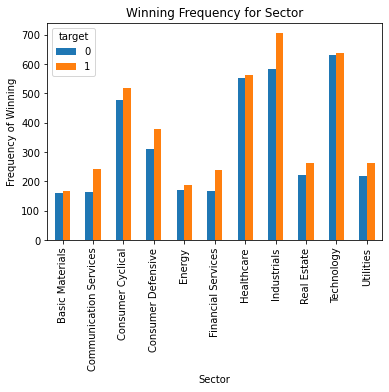

In [15]:
pd.crosstab(df_explore.Sector,df_explore.target).plot(kind='bar')
plt.title('Winning Frequency for Sector')
plt.xlabel('Sector')
plt.ylabel('Frequency of Winning')
plt.savefig('winning_fre_sector')

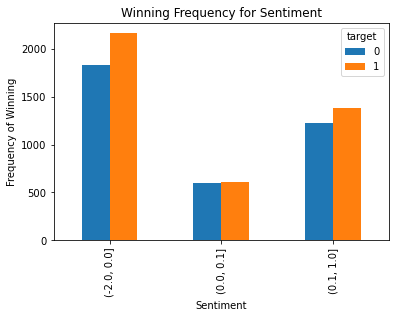

In [16]:
create_quantile_bin(df_explore,'cs_last5',3)
pd.crosstab(df_explore.qbin_cs_last5,df_explore.target).plot(kind='bar')
plt.title('Winning Frequency for Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Frequency of Winning')
plt.savefig('winning_fre_sentiment')

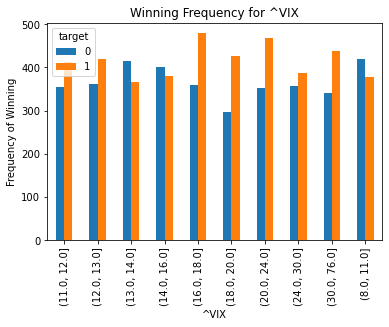

In [17]:
create_quantile_bin(df_explore,'^VIX',10)
pd.crosstab(df_explore['qbin_^VIX'],df_explore.target).plot(kind='bar')
plt.title('Winning Frequency for ^VIX')
plt.xlabel('^VIX')
plt.ylabel('Frequency of Winning')
plt.savefig('winning_fre_^VIX')

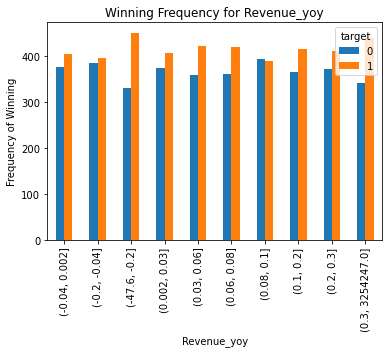

In [18]:
create_quantile_bin(df_explore,'Revenue_yoy',10)

pd.crosstab(df_explore.qbin_Revenue_yoy,df_explore.target).plot(kind='bar')
plt.title('Winning Frequency for Revenue_yoy')
plt.xlabel('Revenue_yoy')
plt.ylabel('Frequency of Winning')
plt.savefig('winning_fre_Revenue_yoy')

### Step 4. Data preprocessing

In [19]:
dfmdl1_clean=dfmdl1.drop(columns=['Ticker', 'Fiscal Year', 'Fiscal Period', 'Shares', 'Next_EarningDate','Industry'
                                 ,'EPSsuprise_ind','T0_5'])

In [20]:
# encode the categorical column
char_var_list=['Sector']
               #, 'qbin_beta_30avg','qbin_cs_last5', 'qbin_Market_cap_mm']
for var in char_var_list:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(dfmdl1_clean[var], prefix=var)
    data1=dfmdl1_clean.join(cat_list)
    dfmdl1_clean=data1

data_vars=dfmdl1_clean.columns.values.tolist()
to_keep=[i for i in data_vars if i not in char_var_list]

dfmdl1_clean=dfmdl1_clean[to_keep]
dfmdl1_clean.columns.values

array(['beta_30avg', 'adjclose', 'Revenue', 'Net_income', 'Cash',
       'Assets', 'CFO', 'CAPX', 'Dividends', 'FCF', 'Revenue_qoq',
       'Revenue_yoy', 'Net_Income_qoq', 'Net_Income_yoy', 'Gross_margin',
       'Gross_margin_qoq', 'Gross_margin_yoy', 'Operating_margin',
       'Operating_margin_qoq', 'Operating_margin_yoy', 'Net_margin',
       'Net_margin_qoq', 'Net_margin_yoy', 'Cash_yoy', 'Assets_yoy',
       'Leverage', 'CFO_qoq', 'FCF_qoq', 'RSI', 'MFI', 'adjclose_SMA_12',
       'adjclose_SMA_30', 'adjclose_EWMA_12', 'adjclose_EWMA_30',
       'adjclose_UpperBand', 'adjclose_LowerBand', 'SMA_12_SMA_30',
       'EWMA_12_EWMA_30', 'UpperBand_LowerBand', '^GSPC',
       '^GSPC_pctchange_5', '^GSPC_pctchange_21', '^GSPC_pctchange_yoy',
       '^RUT', '^RUT_pctchange_5', '^RUT_pctchange_21',
       '^RUT_pctchange_yoy', '^VIX', '^VIX_pctchange_5',
       '^VIX_pctchange_21', '^VIX_pctchange_yoy', 'GC=F',
       'GC=F_pctchange_5', 'GC=F_pctchange_21', 'GC=F_pctchange_yoy',
       '

In [21]:
X=dfmdl1_clean.drop(columns='target')
y=dfmdl1_clean[['target']]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    train_size=0.7)

In [23]:
# Scale the training and testing data
data_scaler = StandardScaler()
data_scaler.fit(X_train)

X_train_s=data_scaler.transform(X_train)
X_test_s=data_scaler.transform(X_test)

X_train_s = pd.DataFrame(data=X_train_s,columns=X_train.columns )
X_test_s = pd.DataFrame(data=X_test_s,columns=X_test.columns )
X_train_s.head()

,beta_30avg,adjclose,Revenue,Net_income,Cash,Assets,CFO,CAPX,Dividends,FCF,Revenue_qoq,Revenue_yoy,Net_Income_qoq,Net_Income_yoy,Gross_margin,Gross_margin_qoq,Gross_margin_yoy,Operating_margin,Operating_margin_qoq,Operating_margin_yoy,Net_margin,Net_margin_qoq,Net_margin_yoy,Cash_yoy,Assets_yoy,Leverage,CFO_qoq,FCF_qoq,RSI,MFI,adjclose_SMA_12,adjclose_SMA_30,adjclose_EWMA_12,adjclose_EWMA_30,adjclose_UpperBand,adjclose_LowerBand,SMA_12_SMA_30,EWMA_12_EWMA_30,UpperBand_LowerBand,^GSPC,^GSPC_pctchange_5,^GSPC_pctchange_21,^GSPC_pctchange_yoy,^RUT,^RUT_pctchange_5,^RUT_pctchange_21,^RUT_pctchange_yoy,^VIX,^VIX_pctchange_5,^VIX_pctchange_21,^VIX_pctchange_yoy,GC=F,GC=F_pctchange_5,GC=F_pctchange_21,GC=F_pctchange_yoy,CL=F,CL=F_pctchange_5,CL=F_pctchange_21,CL=F_pctchange_yoy,^TNX,^TNX_pctchange_5,^TNX_pctchange_21,^TNX_pctchange_yoy,^FVX,^FVX_pctchange_5,^FVX_pctchange_21,^FVX_pctchange_yoy,cs_last5,T0,sameday_jump,PE_new,PS_new,PB_new,Dividend_yields_new,Market_cap_mm,Sector_Basic Materials,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Utilities
0,-0.021923,-0.395954,1.435243,3.382607,11.657338,3.223545,5.571434,-16.046262,-4.996960,3.460407,-0.163486,-0.013622,-0.014227,-0.01354,0.298648,-0.122471,-0.045837,0.108690,-0.046834,-0.063269,0.086959,0.014760,-0.032836,-0.177508,-0.273254,-0.312898,0.030689,-0.109308,1.025424,1.344855,0.340498,0.104380,-0.029747,-0.001957,0.806544,-0.443682,-0.232699,0.119183,-0.492405,-1.238522,0.600397,-0.145970,0.736473,-0.771965,0.627657,-0.291421,1.160693,-0.887860,-0.898366,-0.253328,-1.090485,-1.090045,-0.582563,1.078504,-0.271937,0.032619,0.299901,0.036379,0.770408,0.644681,0.265776,0.142025,0.598525,0.337704,0.186394,0.065911,0.677720,0.094671,-0.363579,-0.211353,-0.025759,0.115756,-0.021529,-0.050527,3.707938,-0.206215,-0.227488,-0.381000,-0.315177,-0.218907,-0.235816,-0.414328,-0.444216,-0.256305,2.286187,-0.25468
1,-0.344217,-0.289055,0.351727,1.084594,0.918200,-0.017759,2.101742,0.020999,-0.993283,1.745845,0.721813,-0.013594,0.096366,-0.01354,0.505920,0.512761,0.005500,0.253936,0.304247,0.053309,0.072624,0.055554,-0.032170,-0.371023,-1.541843,-0.601445,0.237706,0.596911,0.764648,0.122663,0.640925,0.877415,0.314215,0.528078,0.632247,0.602240,0.774784,0.908567,0.063467,0.316350,0.377562,0.906782,-0.156879,0.056202,0.260739,0.945070,-0.492797,-0.655817,-0.046223,-0.892496,-0.866862,0.134556,-0.180492,-0.416678,0.913820,0.239420,0.118469,0.378594,-0.367711,-0.249689,1.367609,0.246475,-0.742091,-0.041276,1.039759,0.208317,-0.683796,0.264586,-0.234366,-0.131158,-0.044814,-0.185313,0.245852,-0.215879,0.424828,-0.206215,-0.227488,-0.381000,-0.315177,-0.218907,-0.235816,-0.414328,-0.444216,-0.256305,2.286187,-0.25468
2,0.690961,-0.538232,-0.263749,-0.182080,-0.185812,-0.119329,-0.184549,-0.016604,0.361023,0.127459,-0.045840,-0.013606,-0.005483,-0.01354,-0.024516,-0.014550,-0.021987,0.030004,0.005704,-0.045012,0.014340,0.016655,-0.041612,-0.273623,-0.061661,-0.247935,0.028621,-0.064804,0.812936,1.397850,1.056462,0.738036,0.772975,0.643086,1.012891,0.167702,-0.008188,-0.043725,-0.255400,-0.645155,0.191867,-0.090110,0.609514,-0.361133,-0.308616,-0.621583,0.363272,-0.986974,-0.333827,-0.167939,-0.802210,-0.714967,0.243024,-0.478529,-0.735624,0.276435,0.294497,0.651638,0.167769,0.414700,-0.244878,0.084112,-0.143815,0.383641,0.033795,0.342255,-0.024240,-3.566049,-0.542606,0.750071,-0.023306,-0.272457,-0.650135,0.190723,-0.280045,-0.206215,-0.227488,2.624669,-0.315177,-0.218907,-0.235816,-0.414328,-0.444216,-0.256305,-0.437410,-0.25468
3,0.408706,0.504672,-0.268671,-0.197752,-0.314699,-0.531007,-0.282714,-0.016604,0.340654,-0.057522,-0.016351,-0.013609,-0.002749,-0.01354,-0.063731,-0.004662,-0.023801,0.001075,0.017387,-0.011904,0.011287,0.017131,-0.031351,-0.177508,-0.273254,-0.232183,0.053502,0.001825,1.625381,1.617891,0.902672,0.695654,-0.082671,0.0

### Step 5. Feature Selection

#### SKlearn RFE

In [24]:
data_final_vars=X.columns.values.tolist()

logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=40,step=1)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False  True  True  True  True  True  True  True  True  True False  True
  True  True False False False False False False False False False False
 False False  True  True  True  True False False False False False False
 False False False  True False False  True  True False False  True  True
  True  True  True  True False False  True  True  True  True  True False
  True  True  True False  True  True  True False  True False  True  True
 False False  True False False False False False False False False False
 False False]
[22  1  1  1  1  1  1  1  1  1 25  1  1  1 27 42 21 39 35 11 41 29  2  7
 31 12  1  1  1  1 17 19 16 18 20 13 15 14  8  1  9  5  1  1 10  3  1  1
  1  1  1  1 23 24  1  1  1  1  1  4  1  1  1  6  1  1  1 43  1 45  1  1
 26 44  1 46 33 36 30 40 32 47 28 38 37 34]


In [25]:
df=pd.DataFrame(list(zip(data_final_vars,rfe.support_,rfe.ranking_)),columns=['variable','Important','Rank']).sort_values(by=['Rank'])
selected_vars=df[df['Important']==True]

In [26]:
selected_feature=list(selected_vars.variable.values)
X_train_subset=X_train_s[selected_feature]
X_test_subset=X_test_s[selected_feature]

### Not scaling (discard)

In [27]:
# Not the training and testing data
# absX_train_s=X_train_subset
# X_test_s=X_test_subset

### Step 5. Model fitting

#### 1) Logistic Regression using StatsmodelAPI

In [28]:
# compare with statsmodels  , 
import statsmodels.api as sm
sm_model = sm.Logit(y_train.values.ravel(), sm.add_constant(X_train_subset)).fit(disp=0)

/Users/feiyiyang/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [29]:
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df

sm_model_results=results_summary_to_dataframe(sm_model)
sm_model_results

,coeff,pvals,conf_lower,conf_higher
const,0.176874,0.750841,-0.914884,1.268631
^GSPC_pctchange_yoy,-0.615485,0.000008,-0.885891,-0.345079
FCF_qoq,0.032114,0.299627,-0.028569,0.092797
RSI,0.117293,0.011740,0.026062,0.208524
CL=F_pctchange_yoy,-0.059303,0.356356,-0.185321,0.066716
^GSPC,0.470691,0.070140,-0.038715,0.980097
^TNX_pctchange_yoy,-0.286476,0.182657,-0.707814,0.134862
^RUT,-0.594007,0.015491,-1.074958,-0.113057
^RUT_pctchange_yoy,0.893895,0.000005,0.509621,1.278169
^VIX,0.536954,0.000037,0.281925,0.791984


In [30]:
select_p=sm_model_results[sm_model_results['pvals']<0.05].index
list(select_p)

['^GSPC_pctchange_yoy',
 'RSI',
 '^RUT',
 '^RUT_pctchange_yoy',
 '^VIX',
 '^VIX_pctchange_yoy',
 '^TNX_pctchange_5',
 'GC=F_pctchange_yoy',
 'CL=F',
 'CL=F_pctchange_5',
 '^VIX_pctchange_21',
 '^FVX_pctchange_5',
 'MFI',
 '^FVX_pctchange_21',
 'Revenue']

#### 2) Logistic Regression using SKlearn

In [31]:
model1 = LogisticRegression(solver='lbfgs', random_state=1,max_iter=10000)
model1.fit(X_train_subset[list(select_p)], y_train.values.ravel())

# get importance

coef = model1.coef_[0]

importance=pd.DataFrame({'variable':select_p,'coef':coef}).sort_values(by=['coef'])
importance

,variable,coef
6,^TNX_pctchange_5,-0.314295
5,^VIX_pctchange_yoy,-0.281058
0,^GSPC_pctchange_yoy,-0.274314
2,^RUT,-0.163081
9,CL=F_pctchange_5,-0.145788
10,^VIX_pctchange_21,-0.144376
12,MFI,-0.129724
13,^FVX_pctchange_21,-0.103485
7,GC=F_pctchange_yoy,-0.093147
14,Revenue,-0.067049


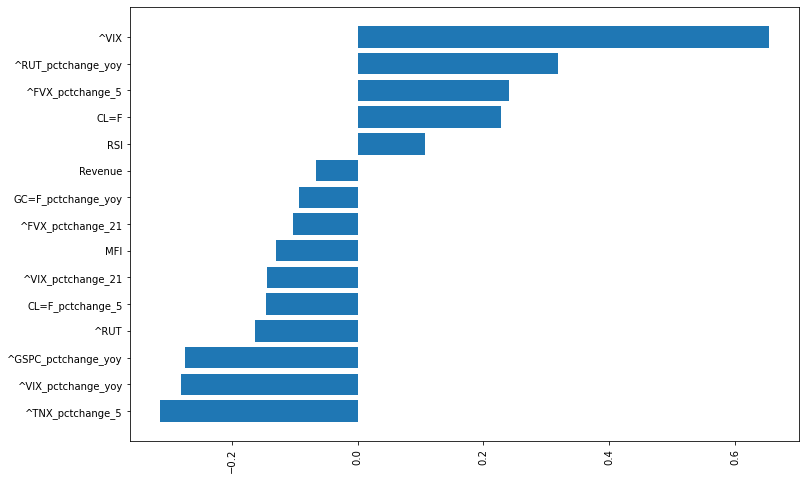

In [38]:
# plot feature importance
plt.rcParams['figure.figsize'] = (12, 8)
plt.barh(importance['variable'], importance['coef'])
plt.xticks(rotation=90)
plt.show()

### Step 6. Prediction and Model Benefit Evaluation with Lift and Gain Analysis

In [33]:
# Predict outcomes for test data set
y_pred = model1.predict_proba(X_test_subset[list(select_p)])[:,1]

df_result=pd.DataFrame({"Prediction": y_pred, "Actual": y_test.values.ravel()}).sort_values(by=['Prediction'],ascending=False)
df_result[:10]

,Prediction,Actual
515,0.965518,1
981,0.947529,1
763,0.918231,1
855,0.879442,1
1454,0.858688,1
230,0.832980,1
977,0.824618,1
1984,0.819579,1
1099,0.804903,0
1474,0.798713,1


In [34]:
df_result['Decile'] = pd.qcut(df_result['Prediction'], 10, labels=[i for i in range (10, 0, -1)])
#Calculate the actual churn in each decile
res = pd.crosstab(df_result['Decile'], df_result['Actual'])[1].reset_index().rename(columns = {1: 'Number of Responses'})
lg = df_result['Decile'].value_counts(sort = False).reset_index().rename(columns = {'Decile': 'Number of Cases', 'index': 'Decile'})
lg = pd.merge(lg, res, on = 'Decile').sort_values(by = 'Decile', ascending = False).reset_index(drop = True)
lg

#Calculate the cumulative
lg['Cumulative Responses'] = lg['Number of Responses'].cumsum()
#Calculate the percentage of positive in each decile compared to the total nu
lg['% of Events'] = np.round(((lg['Number of Responses']/lg['Number of Responses'].sum())*100),2)
#Calculate the Gain in each decile
lg['Gain'] = lg['% of Events'].cumsum()
#Calculate the Lift - measures how much better we can expect to do with the predictive model comparing without the model.
lg['Decile'] = lg['Decile'].astype('int')
lg['lift'] = np.round((lg['Gain']/(lg['Decile']*10)),2)
lg

,Decile,Number of Cases,Number of Responses,Cumulative Responses,% of Events,Gain,lift
0,1,235,171,171,13.59,13.59,1.36
1,2,234,140,311,11.13,24.72,1.24
2,3,234,141,452,11.21,35.93,1.20
3,4,235,141,593,11.21,47.14,1.18
4,5,234,120,713,9.54,56.68,1.13
5,6,234,119,832,9.46,66.14,1.10
6,7,235,114,946,9.06,75.20,1.07
7,8,234,122,1068,9.70,84.90,1.06
8,9,234,97,1165,7.71,92.61,1.03
9,10,235,93,1258,7.39,100.00,1.00


The lift could be interpreted as the gain ratio percentage to the random percentage at a given decile level. In a layman term, in decile 2, we have 1.24 means that when selecting 20% of the data based on the model, we could find the target (actual positive return) 1.24 times more than the randomly selected 20% of the data without a model.

In [39]:
# calculate the fpr and tpr for all thresholds of the classification
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# ROC
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()